# Main.py
*   Step 1 - Cluster NC data
*   Step 2 - Model EC/NC relationship
*   Step 3 - Prep EC data for classification model
*   Step 4 - Classification model for EC data
*   Step 5 - Output results to InfluxDB

# Modules 
* data_preparation
  * scale_continuous
  * encode_units
  * correct_df_units
  * equip_label
  * nav_label
  * connect_to_db
  * query_db_ec
  * query_db_nc
  * query_csv
  * query_weather_csv
* aggregation
  * split_datetime
  * agg_numberic_by_col
  * agg_bool_by_col
  * agg_cat_by_col
  * combined_mixed_agg
  * agg_all
  * append_agg
* clustering
  * make_categorical_list
  * calc_gowers
  * multidim_scale
  * cluster






# Main.py

## Library Imports

In [10]:
### ~ Library Imports ~ ###
# General Imports
from os import listdir
from os.path import isfile, join
from datetime import datetime, timedelta
# Data Formatting and Manipulation Imports
import pandas as pd
# Clustering Step Imports
from sklearn.cluster import AgglomerativeClustering
# Regression Step Imports
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
# Supervised Classification Step Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.ensemble import BaggingClassifier # Selected for Pharmacy (others listed below are alternatives integrated in the last step to test which is optimal for the current data)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Modules Developed for this Project Imports
import data_preparation
import aggregation
import clustering

## Constant Definitions
Throughout the code there are several user defined constants that can be used to change how the code acts. The following things can be changed:
* The site from which to query sensor data
* The measurement within the InfluxDB to query from
* The path to the metadata csv
* The path to the training data
* The numerical index for which column(s) make up the uniqe sensor ids
* Whether or not to display the prediction metrics of the current model
* Whether or not to save the outputs for each step
* The path to save the outputs for each step (if saving step outputs)
* The path to save the final end use labels
* Whether to query form the database or pull data from previously queried csv's
* The start and end date of the date range to query (if querying from database)
* The path to the csv's to pull sensor data from (if pulling data from csv's)

The easiest way to change any of the items listed above is to update them in the following code chunk. This includes running the code for different buildings or pulling data from different measurements.

The comments preceeding each variable in the following chunk of code identify which variables modify each of the above listed options.

In [11]:
#0) Set Constants
### ~ Required for base functionality ~ ###
# String defining which site to run the model for
QUERY_SITE = 'Pharmacy'
# String defining which measurement from the database to query
MEASUREMENT='UBC_EWS'
# String defining the path to the metadata csv for the given building
METADATA_CSV_PATH = '../data/PharmacyQuery.csv'
# String defining the path to the training dataset
TRAINING_SET_PATH = '../data/FinalPharmacyECSensorList-WithLabels - PharmacyECSensorsWithLabels.csv'
# List of indices that can be combined to uniquely identify a sensor (used to group on each sensors)
SENSOR_ID_TAGS = [1,2,3,4,5,6] # order is ["groupRef","equipRef","navName","siteRef","typeRef","unit"]
                                # The planned update to the InfluxDB may change SENSOR_ID_TAGS to only [1] as in ["uniqueID"]
### ~ Alows customization of outputs ~ ###
# Boolean defining if the prediction metrics should be shown (show if True, else False)
DISPLAY_PREDICTION_METRICS = True
# Boolean defining if the output dataframes from each step should be saved (save if True, else False)
SAVE_STEP_OUTPUTS = True
# Strings defining the location to save the dataframe csv's
STEP1_SAVE_PATH = '../data/csv_outputs/step1_clustering_phase_output.csv'
STEP2_SAVE_PATH_FINAL_DF = '../data/csv_outputs/step2_ridge_regression_output.csv'
STEP2_SAVE_PATH_EC_DATA2 = '../data/csv_outputs/step2_aggregated_ec_data_output.csv'
STEP3_SAVE_PATH = '../data/csv_outputs/step3_data_prep_for_classification_output.csv'
PREDICTED_SAVE_PATH = '../data/csv_outputs/predicted_end_use_labels.csv'
# Boolean defining if the model should query from the database or pull from csv's (from database if True, else False)
QUERY_FROM_DB = False
# Strings defining the start and end date fo the date range to query (if QUERY_FROM_DB==True)
START_DATE = '2020-03-16'
END_DATE = '2020-03-17'
# Strings containing the paths to the folders that contains the csv's to pull data from if QUERY_FROM_DB==False
# All file names within the folders must be formatted as "YYYY-MM-DD.csv"
QUERY_CSV_PATH = '../data/sensor_data/'
QUERY_WEATHER_CSV_PATH = '../data/weather_data/'

## Generating DATELIST and client
In this section the following are generated
* The `DATELIST` for the desired date range to collect data from corresponding with either:
  * The `START_DATE` and `END_DATE` defined above (if `QUERY_FROM_DB`==True)
  * The dates of the csv's available in `QUERY_CSV_PATH` (if `QUERY_FROM_DB`==False)
* The `client` of the InfluxDB to query from (if `QUERY_FROM_DB`==True)

If there is a need to update which days are queried, for example randomly sampling days between a date range rather than collecting every date, updating how `DATELIST` is generated in this chunk would be the easiest method. 

In [12]:
if QUERY_FROM_DB:
    # Generating a list of the dates within the daterange to query (if QUERY_FROM_DB==True)
    DELTA = (datetime.strptime(END_DATE, "%Y-%m-%d")-datetime.strptime(START_DATE, "%Y-%m-%d")).days
    DATELIST =  [(datetime.strptime(END_DATE, "%Y-%m-%d") - timedelta(days=x)).strftime('%Y-%m-%d') for x in range(0,delta+1)]
    DATELIST.sort(key=lambda date: datetime.strptime(date, "%Y-%m-%d"))
else:
    # Getting the list of files stored in the path provided in QUERY_CSV_PATH (if QUERY_FROM_DB==False)
    # All files names must be formatted as "YYYY-MM-DD.csv"
    DATELIST = [f.split(".")[0] for f in listdir(QUERY_CSV_PATH) if isfile(join(QUERY_CSV_PATH, f))]

# Connecting to influxDB if QUERY_FROM_DB==True
if QUERY_FROM_DB:
    client = data_preparation.connect_to_db()

### Step 1 - Cluster NC data
The purpose of step 1 is to cluster the non-energy consumption (NC) sensors into groups of sensors that have similar responses, and then aggregate the sensor values for each cluster for each hour of each day in the desired date range. The following aggregations were calculated on the values measured by the sensors within each cluster:
* Mean
* Minimum
* Maximum
* Standard Deviation
* Average Sensor Update Rate

The activities required to attain the goal of Step 1 are the following:
1. For each day in the desired date range:

    1. Collect the non-energy consumption sensor data for the desired building and store in `temp_df`

    2. Aggregate the data for each non-energy consumption sensor to get the previously listed aggregations over the entire time range (meaning only 5 measurements per sensor) and store in `temp_df`

    3. Combine the current day's aggregations with the aggregations of all the previous days using weighted averages and store in `nc_data`
2. Encode the unit of measure and scale the aggregated values for the sensors and store outputs in `nc_data`
3. Calculate the Gower's distance between sensors and store the results in `gow_dist`
4. Cluster the sensors using the Gower's distance and store the results in `clusters`
5. For each day in the desired date range:
    1. Collect the non-energy consumption sensor data for the desired building and store the results in `temp_df`
    2. Assign each sensor it's appropriate cluster number as identified in activity 4 by joining the clusters to `temp_df`
    3. Aggregate the data for each cluster by hour of the day and date to get the previously listed aggregations (so 1 row per hour per day, and 5 columns per cluster) and store the results in `temp_df_aggs`
    4. Combine the current day's aggregations with the aggregations of all the previous days using weighted averages and store the results in `nc_data`

In [13]:
##### 1) Cluster NC data
###########################################################################
print("####### ~~~~~ Started - Step 1: Clustering Phase ~~~~~ #######") # For tracking program progress
###   a) load+aggregate NC data including weather, grouping by sensor ID fields
print("\t##### ~~~ Started - Step 1 a): Aggregation Phase 1 ~~~ #####") # For tracking program progress
last_idx_as_cols = False
is_first_iter = True
cnt=1
for day in DATELIST:
    print("\t\t"+str(cnt)+": "+str(day)) # For tracking program progress
    # Querying and preping data for aggregations
    if QUERY_FROM_DB:
        temp_df = data_preparation.query_db_nc(client, day, measurement=MEASUREMENT, num_days=1, site=QUERY_SITE)
        if temp_df is not None:
            # Making the datetime index into a column so that date and hour can be extracted later
            temp_df.reset_index(level=0, inplace=True)
    else:
        temp_df = data_preparation.query_csv(client=QUERY_CSV_PATH, date=day, site=None)
        weather_df = data_preparation.query_weather_csv(client=QUERY_WEATHER_CSV_PATH, date=day, site=None)
        if weather_df is None:
            pass
        else:
            temp_df = pd.concat([temp_df, weather_df])
            temp_df = temp_df.fillna('empty') # Aggregation doesn't work with nan's, using empty as an obvious flag for value being nan
    if temp_df is None:
        continue
    # Formatting the dataframe columns for date, month, and hour extraction
    col_names = ['datetime']
    col_names.extend(temp_df.columns[1:])
    temp_df.columns = col_names
    # Getting date, month, and hour
    temp_df = aggregation.split_datetime(temp_df)
    if is_first_iter:
        # Creating a low memory dataframe for the append_agg function before the structure is changed by agg_all
        struct_df = temp_df.head(1)
        # Aggregating the first date's data
        nc_data = aggregation.agg_all(temp_df, how="all", col_idx=SENSOR_ID_TAGS, last_idx_to_col=last_idx_as_cols)
        is_first_iter = False
    else:
        # Aggregating the current date's data and aggregate it with the current running total
        temp_df = aggregation.agg_all(temp_df, how="all", col_idx=SENSOR_ID_TAGS, last_idx_to_col=last_idx_as_cols)
        nc_data = aggregation.append_agg(df1=temp_df, df2=nc_data, struct_df=struct_df, col_idx=SENSOR_ID_TAGS, last_idx_to_col=last_idx_as_cols)
    cnt += 1
    
print("\t\t### ~ Started - Step 1 a): Agg Phase 1: Calculating Update Rates ~ ###") # For tracking program progress
# Freeing up some memory
temp_df = None
weather_df = None
struct_df = None
# Calculating the update rate
nc_data["update_rate"] = nc_data["count"] / cnt
nc_data.drop("count", inplace=True, axis=1)

###   b) Encode and scale NC data
print("\t##### ~~~ Step 1 b): Started - Clustering Phase ~~~ #####") # For tracking program progress

# Getting Indexes of the continuous columns
cont_cols = [i for i in range(len(SENSOR_ID_TAGS),len(nc_data.columns))]

# Scale Continuous
scaled_data = data_preparation.scale_continuous(nc_data, cont_cols)
nc_data = pd.concat([nc_data.iloc[:, 0:len(SENSOR_ID_TAGS)], pd.DataFrame(scaled_data, index=nc_data.index, columns=nc_data.columns[cont_cols].tolist())], axis=1)
scaled_data = None

# Encoding units
nc_data = data_preparation.encode_units(nc_data)

###   c) cluster NC data to get df of sensor id fields + cluster group number
# Calculating Gower's Distance, and clusters
print("\t\t### ~ Started - Step 1 c): Clust Phase 1: Calculating Gower's Distance ~ ###") # For tracking program progress
gow_dist = clustering.calc_gowers(nc_data, cont_cols)
print("\t\t### ~ Started - Step 1 c): Clust Phase 2: Calculating Clusters ~ ###") # For tracking program progress
clusters = AgglomerativeClustering(linkage = 'single', affinity='precomputed', n_clusters=20).fit_predict(gow_dist)

# Generating a list of the columns to keep when making the dataframe relating sensors to clusters(the unique identifiers for an NC sensor and cluster)
unique_cols_idx = [i for i in range(len(SENSOR_ID_TAGS))]
unique_cols = nc_data.columns[unique_cols_idx].values.tolist()
unique_cols.append("cluster")
# Creating a dataframe that identifies which unique sensors belong to which cluster
drop_cols = list(set(nc_data.columns.tolist())-set(unique_cols))
cluster_groups = pd.concat([nc_data, pd.DataFrame(clusters, columns=["cluster"])], axis=1)
cluster_groups = cluster_groups.drop(drop_cols, axis=1)

###   d) Reload NC data + join cluster group num + aggregate, this time grouping by date, time, and clust_group_num
print("\t##### ~~~ Started - Step 1 d): Aggregation Phase 2 ~~~ #####") # For tracking program progress
last_idx_as_cols = True
is_first_iter = True
cnt=1
for day in DATELIST:
    print("\t\t"+str(cnt)+": "+str(day)) # For tracking program progress
    # Querying and preping data for aggregations
    if QUERY_FROM_DB:
        temp_df = data_preparation.query_db_nc(client, day, measurement=MEASUREMENT, num_days=1, site=QUERY_SITE)
        if temp_df is not None:
            # Making the datetime index into a column so that date and hour can be extracted later
            temp_df.reset_index(level=0, inplace=True)
    else:
        temp_df = data_preparation.query_csv(client=QUERY_CSV_PATH, date=day, site=None)
        weather_df = data_preparation.query_weather_csv(client=QUERY_WEATHER_CSV_PATH, date=day, site=None)
        if weather_df is None:
            pass
        else:
            temp_df = pd.concat([temp_df, weather_df])
            temp_df = temp_df.fillna('empty') # Aggregation doesn't work with nan's, using empty as an obvious flag for value being nan
    if temp_df is None:
        continue
      # Formatting the dataframe columns for date, month, and hour extraction
    col_names = ['datetime']
    col_names.extend(temp_df.columns[1:])
    temp_df.columns = col_names
    # Getting date, month, and hour (must have at least hour for aggregations)
    temp_df = aggregation.split_datetime(temp_df)
    # Adding cluster groupings to the data for aggregation purposes
    temp_df = temp_df.merge(cluster_groups, how='left', on=cluster_groups.columns[:-1].tolist())
    if is_first_iter:
        # Calculating the count of sensor updates per hour per day per cluster for the first date
        update_rates = temp_df.groupby(['hour','date','cluster']).agg({'value':'count'},axis=1)
        # Creating a low memory dataframe for the append_agg function before the structure is changed by agg_all (different structure required than previous)
        struct_df = temp_df.head(1)
        # Identifying the indexes of the items being aggregated on (hour, date, and cluster)
        cluster_id_tags = [temp_df.columns.tolist().index("hour"), temp_df.columns.tolist().index("date"), temp_df.columns.tolist().index("cluster")]
        # Aggregating the first date's data (Aggregations must be seperate b/c data gets too big during calculations otherwise)
        temp_df_aggs = aggregation.agg_all(temp_df, how="mean", col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols)
        if 'count_x' in temp_df_aggs.columns.tolist():
            # Each aggregation type outputs a count, ensuring joins only result in 1 count (applies for all similar if statements)
            temp_df_aggs = temp_df_aggs.drop('count_y', axis=1)
            temp_df_aggs = temp_df_aggs.rename(columns={'count_x':'count'})
        temp_df_aggs = temp_df_aggs.merge(aggregation.agg_all(temp_df, how="std", col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols), how='left', on=temp_df_aggs.columns.tolist()[:2])
        if 'count_x' in temp_df_aggs.columns.tolist():
            temp_df_aggs = temp_df_aggs.drop('count_y', axis=1)
            temp_df_aggs = temp_df_aggs.rename(columns={'count_x':'count'})
        temp_df_aggs = temp_df_aggs.merge(aggregation.agg_all(temp_df, how="max", col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols), how='left', on=temp_df_aggs.columns.tolist()[:2])
        if 'count_x' in temp_df_aggs.columns.tolist():
            temp_df_aggs = temp_df_aggs.drop('count_y', axis=1)
            temp_df_aggs = temp_df_aggs.rename(columns={'count_x':'count'})
        nc_data = temp_df_aggs.merge(aggregation.agg_all(temp_df, how="min", col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols), how='left', on=temp_df_aggs.columns.tolist()[:2])
        if 'count_x' in nc_data.columns.tolist():
            nc_data = nc_data.drop('count_y', axis=1)
            nc_data = nc_data.rename(columns={'count_x':'count'})
        is_first_iter = False
    else:
        # Calculating the count of sensor updates per hour per day per cluster for the current date
        update_rates = pd.concat([update_rates, temp_df.groupby(['hour','date','cluster']).agg({'value':'count'},axis=1)])
        # Aggregating the current date's data and aggregate it with the current running total
        temp_df_aggs = aggregation.agg_all(temp_df, how="mean", col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols)
        if 'count_x' in temp_df_aggs.columns.tolist():
            temp_df_aggs = temp_df_aggs.drop('count_y', axis=1)
            temp_df_aggs = temp_df_aggs.rename(columns={'count_x':'count'})
        temp_df_aggs = temp_df_aggs.merge(aggregation.agg_all(temp_df, how="std", col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols), how='left', on=temp_df_aggs.columns.tolist()[:2])
        if 'count_x' in temp_df_aggs.columns.tolist():
            temp_df_aggs = temp_df_aggs.drop('count_y', axis=1)
            temp_df_aggs = temp_df_aggs.rename(columns={'count_x':'count'})
        temp_df_aggs = temp_df_aggs.merge(aggregation.agg_all(temp_df, how="max", col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols), how='left', on=temp_df_aggs.columns.tolist()[:2])
        if 'count_x' in temp_df_aggs.columns.tolist():
            temp_df_aggs = temp_df_aggs.drop('count_y', axis=1)
            temp_df_aggs = temp_df_aggs.rename(columns={'count_x':'count'})
        temp_df_aggs = temp_df_aggs.merge(aggregation.agg_all(temp_df, how="min", col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols), how='left', on=temp_df_aggs.columns.tolist()[:2])
        if 'count_x' in temp_df_aggs.columns.tolist():
            temp_df_aggs = temp_df_aggs.drop('count_y', axis=1)
            temp_df_aggs = temp_df_aggs.rename(columns={'count_x':'count'})
        nc_data = aggregation.append_agg(df1=temp_df_aggs, df2=nc_data, struct_df=struct_df, col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols)
    cnt += 1
    
print("\t\t### ~ Started - Step 1 d): Agg Phase 2: Calculating Update Rates ~ ###") # For tracking program progress
# Re-format update rates so that clusters are columns
update_rates = update_rates.unstack()
update_rates.columns = update_rates.columns.droplevel(level=0)
update_rates = update_rates.fillna(0)

# Calculate the number of sensors per cluster
sensor_count_per_cluster = cluster_groups.groupby('cluster').agg({cluster_groups.columns.tolist()[0]:'count'})
sensor_count_per_cluster.columns = ['count']

# Calculate the average sensor update rate per hour per cluster
for cluster in cluster_groups['cluster'].unique():
    update_rates.loc[:,cluster] = update_rates.loc[:,cluster]/sensor_count_per_cluster.loc[cluster][0]

# Rename the update rate columns and join them to the nc_data
update_rates = update_rates.add_prefix('urate_')
nc_data = nc_data.join(update_rates, how='left', on=['hour', 'date'])
nc_data = nc_data.drop('count', axis=1)
if SAVE_STEP_OUTPUTS:
    nc_data.to_csv(STEP1_SAVE_PATH)

# Freeing up some space
temp_df_aggs = None
struct_df = None
temp_df = None
update_rates = None

print("####### ~~~~~ Complete - Step 1: NC Aggregation and Clustering Phase ~~~~~ #######") # For tracking program progress

####### ~~~~~ Started - Step 1: Clustering Phase ~~~~~ #######
	##### ~~~ Started - Step 1 a): Aggregation Phase 1 ~~~ #####
		1: 2020-03-16
		2: 2020-05-01
		### ~ Started - Step 1 a): Agg Phase 1: Calculating Update Rates ~ ###
	##### ~~~ Step 1 b): Started - Clustering Phase ~~~ #####
		### ~ Started - Step 1 c): Clust Phase 1: Calculating Gower's Distance ~ ###
		### ~ Started - Step 1 c): Clust Phase 2: Calculating Clusters ~ ###
	##### ~~~ Started - Step 1 d): Aggregation Phase 2 ~~~ #####
		1: 2020-03-16
		2: 2020-05-01
		### ~ Started - Step 1 d): Agg Phase 2: Calculating Update Rates ~ ###
####### ~~~~~ Complete - Step 1: NC Aggregation and Clustering Phase ~~~~~ #######


### Ploting Clusters
**WARNING:** The code chunk for plotting of the clusters requires multidimensional scaling to be calculated on the Gower's distance. This calculation can take a long time, so only run this chunk if you want to plot the clusters.

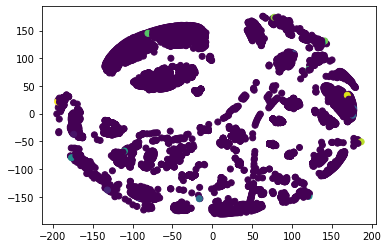

In [14]:
# MDS calculation
mds = clustering.multidim_scale(gow_dist, num_dim=2)

# Preping the dataframe for plotting
data_2d_df = pd.DataFrame(data=mds, columns = ['x','y'])
data_2d_df['cluster'] = cluster_groups['cluster']

# Plotting the clusters
plt.scatter(data_2d_df['x']*1000,data_2d_df['y']*1000, c=data_2d_df['cluster'])
plt.show()

***
***
# Add Chunk for Customizability of Clustering methods
* Add code to plot current cluster (minimum)
  * Make this a seperate chunk and add a warning that it takes a long time b/c need to calculate MDS
* Also see if can get a good way of calculating all/various clusters and comparing plots/sihlouette scores (if have time)
  * Also time consuming so probably need's to be a seperate chunk 
    * Maybe at the end after everything? (in that case just mention here and state that it is at the end)
***
***

### Step 2 - Model EC/NC relationship

1. Query EC data using `data_preparation.query_db_ec`
2. The data is stored in a temp dataframe. Next, `aggregation.split_datetime` is used to split datetime to date and hour. Two dataframes (**ec_data1**, **ec_data2**) are incrementally created from temp dataframe
3. Both **ec_data1** and **ec_data2** dataframes are aggregated using `aggregation.agg_numeric_by_col`. **ec_data1** is aggregated by date and hour whereas **ec_data2** is aggregated by unique sensor ID
4. Scale continuous data in **ec_data1** and **nc_data** using `data_preparation.scale_continuous`
5. For each unique sensor ID
  * Merge **ec_data1** with **nc_data** into a new dataframe 
  * Set X to **nc_data** values and Y to **ec_data1** mean value
  * Use cross validation `RidgeCV()` to find optimal alpha value. Feed X and Y arrays into ridge regression model using `Ridge()` with optimal alpha value as a parameter
  * Store each unique sensor ID's model coeffcients into a list named coefficients_list
5. Append model coefficients for every unique sensor ID into a single dataframe named **final_df**

In [15]:
##### 2) Model EC/NC relationship
###########################################################################
# Freeing up some memory (done here b/c Gower's distance is required to calculate MDS for plotting)
gow_dist = None

print("####### ~~~~~ Starting - Step 2: Model EC/NC Relationship ~~~~~ #######") # For tracking program progress
###   a) Aggregate EC sensors to be response variables for the regression model
print("\t##### ~~~ Started - Step 2 a): Aggregation ~~~ #####") # For tracking program progress
last_idx_as_cols = False
is_first_iter = True
cnt=1
for day in DATELIST:
    print("\t\t"+str(cnt)+": "+str(day)) # For tracking program progress
    # Querying and preping data for aggregations
    if QUERY_FROM_DB:
        temp_df2 = data_preparation.query_db_ec(client, day, measurement=MEASUREMENT, num_days=1, site=QUERY_SITE)
        if temp_df2 is not None:
            # Making the datetime index into a column so that date and hour can be extracted later
            temp_df2.reset_index(level=0, inplace=True)
    else:
        temp_df2 = data_preparation.query_csv(client=QUERY_CSV_PATH, date=day, site=None)
        # Filter for EC data, this step will be done in the query
        if temp_df2 is not None:
            temp_df2=temp_df2[(temp_df2['unit']=='kWh') | (temp_df2['unit']=='m³')]
    if temp_df2 is None:
        continue
    col_names = ['datetime']
    col_names.extend(temp_df2.columns[1:])
    temp_df2.columns = col_names
    temp_df2 = aggregation.split_datetime(temp_df2)
    # Creating uniqueId
    temp_df2=data_preparation.create_unique_id(temp_df2)
    # Filtering dataframe for only relevant fields
    temp_df2=temp_df2[['uniqueId', 'date', 'hour', 'unit', 'value']]
    if is_first_iter:
        # Creating a low memory dataframe for the append_agg function before the structure is changed by agg_all
        struct_df2 = temp_df2.head(1)
        # Aggregating the first date's data
        ec_data1=aggregation.agg_numeric_by_col(temp_df2, col_idx=[0,1,2,3], how='mean')
        # Also create second DF by aggregating further just using sensor ID fields (end result=1row per sensor)
        ec_data2=aggregation.agg_numeric_by_col(temp_df2, col_idx=[0,3], how='all')
        is_first_iter = False
    else:
        # Aggregating the current date's data and aggregate it with the current running total
        temp_df2a=aggregation.agg_numeric_by_col(temp_df2, col_idx=[0,1,2,3], how='mean')
        temp_df2b=aggregation.agg_numeric_by_col(temp_df2, col_idx=[0,3], how='all')
        ec_data1=aggregation.append_agg(df1=temp_df2a, df2=ec_data1, struct_df=struct_df2, col_idx=[0,1,2,3])
        ec_data2=aggregation.append_agg(df1=temp_df2b, df2=ec_data2, struct_df=struct_df2, col_idx=[0,3])
    cnt += 1
# Freeing up some memory
temp_df2 = None
temp_df2a = None
temp_df2b = None
# Calculating the update rate
ec_data2["update_rate"] = ec_data2["count"] / (cnt*24)
ec_data2.drop("count", inplace=True, axis=1)

# Resetting index columns
ec_data1=ec_data1.reset_index()
ec_data2=ec_data2.reset_index()

# Renaming column
ec_data1=ec_data1.rename(columns={"mean":"EC_mean_value"})

# Dataframe with unique sensor ids
uniqueSensors=ec_data2['uniqueId'].unique()

# Scaling EC data
ec_data1['EC_mean_value']=data_preparation.scale_continuous(ec_data1, indexes=[4])


# Scaling Cluster data
for i in range(6,len(nc_data.columns)):
    nc_data.iloc[:,i]=data_preparation.scale_continuous(nc_data, indexes=[i])

###   b) For each unique EC sensorID (i.e. row in 2b_EC_data_df), create Ridge Regression model using
#       2a_EC_data_df and step1_output_NC_data_df. Model is basically: Y=EC response and Xn=NC data
print("\t##### ~~~ Started - Step 2 b): Regression ~~~ #####") # For tracking program progress

# Will store each ridge output into a list and append all the dataframes
coefficients_list=[]

# total sum of mse from each ridge regression model (accumulative)
score=0

# Creating individual data frames for each sensor and implementing Ridge Regression
for sensor in uniqueSensors:
    # Create data frame for only that relevant sensor
    new_df=ec_data1[ec_data1['uniqueId']==sensor]
    # Changing EC data types for merging later
    nc_data = nc_data.astype({"date": str})
    new_df = new_df.astype({"date": object, "hour": object})
    new_df.loc[:,'date']=new_df['date'].apply(lambda x: str(x)[0:10])

    # Merge specific sensor to cluster data
    new_merged=pd.merge(nc_data, new_df, how='inner', left_on=['date','hour'], right_on=['date','hour'])
    # Replacing NaN's with 0 (Ridge Regression doesn't allow NANs)
    new_merged=new_merged.fillna(0)

    # All NC predictor variables
    X=new_merged.iloc[:,2:(len(new_merged.columns)-3)]

    # Mean value of EC data
    Y=new_merged['EC_mean_value']
    Y=Y.to_numpy().reshape(len(Y),1)

    # Ridge CV to find optimal alpha value
    alphas=[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]
    reg=RidgeCV(alphas=alphas, store_cv_values=True)
    reg.fit(X, Y)
    alpha_best=reg.alpha_

    # Ridge model using optimal alpha value found in step above
    ridge_test=Ridge(alpha=alpha_best, tol=.01, max_iter=10e7,normalize=True)
    ridge_test.fit(X,Y)
    coef=ridge_test.coef_
    mse=mean_squared_error(y_true=Y, y_pred=ridge_test.predict(X))
    score=score+mse

    # Store coefficients into a dataframe
    new=pd.DataFrame(data=coef.reshape(1,((len(new_merged.columns)-3)-2)))

    # Add uniqueId to the dataframe
    new['uniqueId']=sensor

    # Store each sensorID's ridge coefficients into a list
    coefficients_list.append(new)

# Append all ridge coefficients for all sensors into a single dataframe
for df in uniqueSensors:
    final_df = pd.concat(coefficients_list)

# calculate the avarge mse across all ridge regression models
avg_mse=score/len(uniqueSensors)
print("avg_mse:",avg_mse)

if SAVE_STEP_OUTPUTS:
    final_df.to_csv(STEP2_SAVE_PATH_FINAL_DF)
    ec_data2.to_csv(STEP2_SAVE_PATH_EC_DATA2)
print("####### ~~~~~ Complete - Step 2: Model EC/NC Relationship ~~~~~ #######") # For tracking program progress


####### ~~~~~ Starting - Step 2: Model EC/NC Relationship ~~~~~ #######
	##### ~~~ Started - Step 2 a): Aggregation ~~~ #####
		1: 2020-03-16
		2: 2020-05-01
	##### ~~~ Started - Step 2 b): Regression ~~~ #####
avg_mse: 0.0002771344309097581
####### ~~~~~ Complete - Step 2: Model EC/NC Relationship ~~~~~ #######


### Step 3 - Prep EC data for classification model


In [16]:
##### 3) Prep EC data for classification model
###########################################################################
print("####### ~~~~~ Starting - Step 3: Prep EC Data for Classification Model ~~~~~ #######") # For tracking program progress
###   a) Load metadata and join with 2b_EC_data_df
metadata=pd.read_csv(METADATA_CSV_PATH, dtype=object)
# Make uniqueIDs
metadata=data_preparation.create_unique_id(metadata, metadata=True)
# Drop duplicates
metadata=metadata.sort_values('lastSynced').drop_duplicates('uniqueId',keep='last')
# Choose relevant fields
metadata=metadata[['uniqueId','kind', 'energy','power', 'sensor', 'unit', 'water']] 
# Changing boolean to easily identify during encoding process
metadata['energy']=metadata['energy'].apply(lambda x: 'yes_energy' if x=='✓' else 'no_energy')
metadata['power']=metadata['power'].apply(lambda x: 'yes_power' if x=='✓' else 'no_power')
metadata['sensor']=metadata['sensor'].apply(lambda x: 'yes_sensor' if x=='✓' else 'no_sensor')
metadata['water']=metadata['water'].apply(lambda x: 'yes_water' if x=='✓' else 'no_water')
metadata['unit']=metadata['unit'].apply(lambda x: 'omit' if x=='_' else x)
# left join metadata and 2b_EC_data_df
merged_left=pd.merge(ec_data2, metadata, how='left', left_on='uniqueId', right_on='uniqueId')

###   b) Apply feature selection function(s) to the joined EC+metadata
# load end_use classifications training data
end_use_labels=pd.read_csv(TRAINING_SET_PATH)
# make uniqueId
end_use_labels['siteRef']=QUERY_SITE
end_use_labels=data_preparation.create_unique_id(end_use_labels)

# rename columns to fix unit of measurements
end_use_labels.rename(columns={'UBC_EWS.firstValue':'value'}, inplace=True)
# run correct_df_units function
end_use_labels=data_preparation.correct_df_units(end_use_labels)

# TRAINING DATA CLEANING
# Change ? to 0 since uom fixed
end_use_labels=end_use_labels.assign(isGas=end_use_labels.isGas.apply(lambda x: '0' if x=='?' else x))
# changing boolean for more descriptive encoding
end_use_labels=end_use_labels.assign(isGas=end_use_labels.isGas.apply(lambda x: 'no_gas' if x=='0' else 'yes_gas'))

# selecting relevant training data fields
end_use_labels=end_use_labels[['uniqueId', 'isGas', 'equipRef', 'groupRef', 'navName', 'endUseLabel']]
end_use_labels=end_use_labels.drop_duplicates()
merged_outer=pd.merge(left=merged_left, right=end_use_labels, how='left', left_on='uniqueId', right_on='uniqueId')
# make equipRef and navName into smaller categories for feature engineering
merged_outer=merged_outer.assign(equipRef=merged_outer.equipRef.apply(lambda x: data_preparation.equip_label(str(x))))
merged_outer=merged_outer.assign(navName=merged_outer.navName.apply(lambda x: data_preparation.nav_label(str(x))))

###   c) Encode and scale the EC+metadata
# encoding after feature selection
merged_outer=merged_outer.assign(energy_no_energy=merged_outer.energy.apply(lambda x: 1 if x=='no_energy' else 0))
merged_outer=merged_outer.assign(energy_yes_energy=merged_outer.energy.apply(lambda x: 1 if x=='yes_energy' else 0))
merged_outer=merged_outer.assign(sensor_no_sensor=merged_outer.sensor.apply(lambda x: 1 if x=='no_sensor' else 0))
merged_outer=merged_outer.assign(sensor_yes_sensor=merged_outer.sensor.apply(lambda x: 1 if x=='yes_sensor' else 0))
merged_outer=merged_outer.assign(equipRef_Air_Equip=merged_outer.equipRef.apply(lambda x: 1 if x=='Air_Equip' else 0))
merged_outer=merged_outer.assign(equipRef_Cooling=merged_outer.equipRef.apply(lambda x: 1 if x=='Cooling' else 0))
merged_outer=merged_outer.assign(equipRef_Heating=merged_outer.equipRef.apply(lambda x: 1 if x=='Heating' else 0))
merged_outer=merged_outer.assign(equipRef_LEED=merged_outer.equipRef.apply(lambda x: 1 if x=='LEED' else 0))
# scaling after feature selection
for i in range(1,6):
    merged_outer.iloc[:,i]=data_preparation.scale_continuous(merged_outer, indexes=[i])

###   d) Join the model coeffecients from step2 output to the EC+metadata
step3_data = pd.merge(merged_outer, final_df, left_on='uniqueId', right_on='uniqueId', how='outer')
# dropping unnessary columns to feed into classification
step3_data = step3_data.drop(['kind', 'energy', 'power', 'sensor', 'water', 'isGas', 'equipRef', 'groupRef', 'navName', 'unit'], axis=1)
# Populating endUseLabel that are null with 99_UNKNOWN so that they can be predicted
step3_data.loc[:, 'endUseLabel'] = step3_data.loc[:, 'endUseLabel'].fillna('99_UNKNOWN')
if SAVE_STEP_OUTPUTS:
    step3_data.to_csv(STEP3_SAVE_PATH)
print("####### ~~~~~ Complete - Step 3: Prep EC Data for Classification Model ~~~~~ #######") # For tracking program progress


####### ~~~~~ Starting - Step 3: Prep EC Data for Classification Model ~~~~~ #######
####### ~~~~~ Complete - Step 3: Prep EC Data for Classification Model ~~~~~ #######


### Step 4 - Classification model for EC data
The purpose of Step 4 is to take the data from the previous steps and predict the end uses of each of the unknown energy consumption sensors. The final output of step is a dataframe of sensor unique ID's and the corresponding sensor end uses. This dataframe is saved to a csv which can then be fed into Step 5.

The activities required to accomplish the goals of this step are the following:
1. Manipulate the dataset such that the known end use labels from the training set are the last column in the dataframe and store updates back in `training_data`
  * NOTE: This allows for any number of predictor variables to be used, this flexibility is required to maintain flexibility in the number of clusters generated in Step 1
2. Extract just the numbers from the end use labels since the classifier works with integers not strings and store updates back in `training_data['endUseLabel']`
3. Prep the data for prediction and classification by creating seperate datasets for training and predicting and store them in `training_data` and `predicting_data` respectively
4. Create and train the `classifier`
5. Predict the end uses of the unlabled sensors and store the results in `y_pred`
6. Create and populate the output dataframe, `sensor_labels`, and save it as a csv
7. If `DISPLAY_PREDICTION_METRICS`==True
  1. Split the training data into a training and testing set
  2. Re-create and train the classifier
  3. Calculate and print the prediction metrics listed below for the currently selected supervised model:
    * Confusion Matrix
    * Accuracy
    * Precision
    * Recall
    * F1 Score
    * Log Loss
  4. Calculate the above metrics for Supervised Classification models imported in the **Library Imports** Section and print the top performing model(s) with its/their performance metrics
    * NOTE: Current functionality just prints the top performing model(s), it doesn't currently implement it/them

The following code chunk is where any changes to the supervised model must be done, this would include modifying the code to automatically select which supervised model to use based on performance on the training dataset.

In [17]:
##### 4) Classification model
###########################################################################
print("####### ~~~~~ Starting - Step 4: Supervised Modeling and Predicting End-Use Labels ~~~~~ #######") # For tracking program progress
###   a) Dataprep to get the step 3 data into an appropriate format for prediction
training_data=step3_data
# Manipulating dataset to be in the appropriate format for creating seperate predictor and response datasets
cols = training_data.columns.tolist()
cols.remove('endUseLabel')
cols.append('endUseLabel')
training_data = training_data[cols]
# Creating End Use Label Dictionary
end_use_labels = {}
for label in training_data['endUseLabel'].unique():
    end_use_labels[int(str(label)[0:2])] = label
# Extracting just the number from the label
training_data['endUseLabel'] = training_data['endUseLabel'].apply(lambda x: int(str(x)[0:2]))
predicting_data = training_data[(training_data['endUseLabel']==99)]
training_data=training_data[(training_data['endUseLabel']!=99)]
# Storing Training and Prediction labels
predicting_labels = predicting_data['uniqueId']
predicting_labels = pd.concat([predicting_labels, predicting_data['endUseLabel']], axis=1)
training_labels = training_data['uniqueId']
training_labels = pd.concat([training_labels, training_data['endUseLabel']], axis=1)
# Dropping uniqueid and filling na's with 0
training_data = training_data.drop('uniqueId', axis=1)
training_data = training_data.fillna(0)
predicting_data = predicting_data.drop('uniqueId', axis=1)
predicting_data = predicting_data.fillna(0)
# Creating seperate predictor variable and response variable numpy arrays
x_train = training_data.iloc[:, :-1].values
y_train = training_data.iloc[:, -1].values
x_pred = predicting_data.iloc[:, :-1].values

###   b) Create and train the selected model
# Creating and fitting the classifier
classifier = BaggingClassifier(n_estimators = 100)
classifier.fit(x_train, y_train)

###   c) Predict the outputs for the new data
# Predicting the outputs
y_pred = classifier.predict(x_pred)

###   d) Create dataframe of sensors and labels to be input for step 5
predicting_labels['endUseLabel'] = y_pred
sensor_labels = pd.concat([training_labels, predicting_labels])
sensor_labels['endUseLabel'] = sensor_labels['endUseLabel'].apply(lambda x: end_use_labels[x])
sensor_labels.to_csv(PREDICTED_SAVE_PATH, index=False)

###   e) Display prediction metrics on a train-test split of the testing data if desired
if DISPLAY_PREDICTION_METRICS:
    print("\t##### ~~~ Step 4: Displaying Prediction Metrics For the Current Model ~~~ #####") # For tracking program progress
    # Creating training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2)
    # Creating the classifier and predicting the output for the test set
    classifier = BaggingClassifier(n_estimators = 100)
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    
    # Calculating and displaying the comparison metrics
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    try:
        logloss = log_loss(y_true=y_test, y_pred=classifier.predict_proba(x_test))
    except:
        logloss = "Unable to calculate logloss: Random train/test split did not provide at least 1 item from each class in both the trianing and testing set"
    print("accuracy: "+str(accuracy))
    print("precision: "+str(precision))
    print("recall: "+str(recall))
    print("f1: "+str(f1))
    print("logloss: "+str(logloss))
    
    print("\t##### ~~~ Step 4: Identifying the Best Supervised Model for the Current Data ~~~ #####")      
    # Initializing the dataframe displaying the results
    models = ['decision_tree', 'knn', 'kernel_svm', 'logistic_regression', 'naive_bayse', 'random_forest', 'extremely_random_trees', 'bagging', 'adaboost', 'gradientboost']
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'logloss']
    results = pd.DataFrame(index=models, columns=metrics)
    
    # Creating a list of the classifier options
    classifier_list = []
    classifier_list.append(DecisionTreeClassifier(criterion = 'entropy', random_state = 0))
    classifier_list.append(KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2))
    classifier_list.append(SVC(kernel = 'rbf', random_state = 0, probability=True))
    classifier_list.append(LogisticRegression(random_state = 0))
    classifier_list.append(GaussianNB())
    classifier_list.append(RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 0))
    classifier_list.append(ExtraTreesClassifier(n_estimators = 100, criterion = 'gini', random_state = 0))
    classifier_list.append(BaggingClassifier(n_estimators = 100, random_state = 0))
    classifier_list.append(AdaBoostClassifier(n_estimators = 100, random_state = 0))
    classifier_list.append(GradientBoostingClassifier(n_estimators = 100, loss='deviance', criterion='friedman_mse', random_state = 0))
    
    # For loop to go through each of the classifiers and calculate their comparison metrics on the training and testing data
    i=0
    for classifier in classifier_list:
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        logloss = log_loss(y_true=y_test, y_pred=classifier.predict_proba(x_test))
        # Storing comparison metrics in dataframe
        results.loc[models[i], 'accuracy'] = accuracy
        results.loc[models[i], 'precision'] = precision
        results.loc[models[i], 'recall'] = recall
        results.loc[models[i], 'f1_score'] = f1
        results.loc[models[i], 'logloss'] = logloss
        i+=1
    
    # Identifying which classifier(s) performed best overall   
    results['num_best'] = 0
    for metric in metrics:
        if metric != 'logloss':
            cur_best = max(results.loc[:,metric])
        else:
            cur_best = min(results.loc[:,metric])
        for model in models:
            if results.loc[model, metric]==cur_best:
                results.loc[model,'num_best'] += 1
    # Printing the best classifier(s) and their associated comparison metrics
    print(results[results['num_best']==results['num_best'].max()])

print("####### ~~~~~ Complete - Step 4: Supervised Modeling and Predicting End-Use Labels ~~~~~ #######") # For tracking program progress

####### ~~~~~ Starting - Step 4: Supervised Modeling and Predicting End-Use Labels ~~~~~ #######
	##### ~~~ Step 4: Displaying Prediction Metrics For the Current Model ~~~ #####
[[5 0 0 0 0 1]
 [0 3 0 0 0 0]
 [0 0 9 0 0 1]
 [0 0 0 2 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 5]]
accuracy: 0.9310344827586207
precision: 0.9507389162561577
recall: 0.9310344827586207
f1: 0.934306770059946
logloss: 0.21560360066287912
	##### ~~~ Step 4: Identifying the Best Supervised Model for the Current Data ~~~ #####


/home/connor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/connor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/connor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9655172413793104
0.971264367816092
0.9655172413793104
0.9661771984820987
0.08775578294010603
                        accuracy precision    recall  f1_score    logloss  \
random_forest           0.965517  0.971264  0.965517  0.966177   0.220271   
extremely_random_trees  0.965517  0.971264  0.965517  0.966177  0.0915465   

                        num_best  
random_forest                  4  
extremely_random_trees         4  
####### ~~~~~ Complete - Step 4: Supervised Modeling and Predicting End-Use Labels ~~~~~ #######


### Step 5 - Output results to InfluxDB

### Running main() function from main.py

In [18]:
main()

NameError: name 'main' is not defined

# Modules

### data_preparation.scale_continuous(df, indexes=[0])
Function to scale continuous data, the user must define which columns have continuous data

Args:
* df (pandas.DataFrame): dataframe to containing at least one column of continuous data 
* indexes (list): list of indexes with continuous data to scale. 

Returns:
* np_arr (numpy.array): numpy array of scaled continuous values

  

In [ ]:
data_preparation.scale_continuous(ec_data2, indexes[1,2,3,4,5])

### data_preparation.encode_units(df)
Function to encode units

Args:
* df (pandas.DataFrame): dataframe to containing a "unit" column. 

Returns:
* encoded_units_df (pandas.DataFrame): dataframe containing encoded units

In [ ]:
data_preparation.encode_units(ec_data1)

### data_preparation.correct_df_units(df)
Function to correct units of measurement column in dataframe

Args:
* df (pandas Dataframe): dataframe containing the columns uniqueId, navName, equipRef, value, and unit

Returns:
* final_df (pandas Dataframe): inputted dataframe with values in units column corrected

In [ ]:
data_preparation.correct_df_units()

### data_preparation.equip_label()

### data_preparation.nav_label()


### data_preparation.connect_to_db()


### data_preparation.query_db_ec()


### data_preparation.query_db_nc()


### data_preparation.query_csv()


### data_preparation.query_weather_csv()